# Challenge 2

## Loading the Dataset


In [3]:
# clone the dataset from github
!git clone https://github.com/DPaletti/xtream-assignment/

Cloning into 'xtream-assignment'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 58 (delta 14), reused 22 (delta 7), pack-reused 24
Unpacking objects: 100% (58/58), 767.49 KiB | 9.36 MiB/s, done.


In [4]:
# load the dataset from the csv file
import pandas as pd
dataset = pd.read_csv("./xtream-assignment/datasets/diamonds/diamonds.csv")

## Pre-Processing
We will use XGBoost therefore normalization is not necessary

In [5]:
seed = 0
target = "price"
test_size = 0.2
categorical_features = ["cut", "color", "clarity"]

In [81]:
from functools import reduce
from typing import List

def convert_to_ordinal(dataset: pd.DataFrame, feature: str) -> pd.DataFrame:
  """Convert a categorical feature to ordinal in a given dataset"""
  categorical_values = dataset[feature].unique()
  ordinal_map = {categorical_value: ordinal_value 
                 for ordinal_value, categorical_value 
                 in enumerate(categorical_values)}
  return dataset.replace(ordinal_map)

def convert_all_to_ordinal(dataset: pd.DataFrame, 
                           features: List[str]) -> pd.DataFrame:
  """Convert a list of categorical features to ordinal in a given dataset"""
  return reduce(convert_to_ordinal, features, dataset)

In [84]:
from sklearn.model_selection import train_test_split

# remove problematic data points
cleaned_dataset = dataset.drop(dataset[dataset.price <=0].index)
cleaned_dataset = cleaned_dataset.drop(
    cleaned_dataset[
      (cleaned_dataset["x"] == 0) 
    | (cleaned_dataset["y"] == 0) 
    | (cleaned_dataset["z"] == 0)].index)

# remove correlated features
cleaned_dataset = cleaned_dataset.drop(["x", "y", "z"], axis=1)

# convert ordinal values to numeric
cleaned_dataset = convert_all_to_ordinal(cleaned_dataset,
                                                categorical_features)

# split
train, test = train_test_split(cleaned_dataset, 
                               test_size=test_size, 
                               random_state=seed)
samples_train = train.drop([target], axis=1)
targets_train = train[target]
samples_test = test.drop([target], axis=1)
targets_test = test[target]

## Training and Evaluation

In [ ]:
# silences some warning present in 0.9 which is default in Colab
!pip install xgboost --upgrade

In [86]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

regressor = XGBRegressor(tree_method="gpu_hist", 
                         sampling_method="gradient_based",
                         random_state=seed)
hyperparameters = {
        # learning rate
        "eta": np.linspace(0, 1, endpoint=False)[1::],
        # L1 regularization
        "alpha": np.linspace(0,1),
        # L2 regularization
        "lambda": np.linspace(0, 1),
        # subsample rate prior to growing the trees
        "subsample": np.linspace(0.1, 1),
    }

hyperparameter_search = RandomizedSearchCV(
                           regressor, 
                           hyperparameters, 
                           scoring="r2",
                           cv=3,
                           n_iter=500,
                           verbose=3,
                           random_state=0)

hyperparameter_search.fit(samples_train, targets_train)
best_regressor = hyperparameter_search.best_estimator_
best_regressor.score(samples_test, targets_test)
predicted_targets = best_regressor.predict(samples_test)
best_regressor.save_model("regressor.json")

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV 1/3] END alpha=0.7346938775510203, eta=0.74, lambda=0.0, subsample=0.3755102040816327;, score=0.917 total time=   0.5s
[CV 2/3] END alpha=0.7346938775510203, eta=0.74, lambda=0.0, subsample=0.3755102040816327;, score=0.937 total time=   0.5s
[CV 3/3] END alpha=0.7346938775510203, eta=0.74, lambda=0.0, subsample=0.3755102040816327;, score=0.927 total time=   0.4s
[CV 1/3] END alpha=0.24489795918367346, eta=0.12, lambda=0.7755102040816326, subsample=0.19183673469387758;, score=0.954 total time=   0.3s
[CV 2/3] END alpha=0.24489795918367346, eta=0.12, lambda=0.7755102040816326, subsample=0.19183673469387758;, score=0.972 total time=   0.2s
[CV 3/3] END alpha=0.24489795918367346, eta=0.12, lambda=0.7755102040816326, subsample=0.19183673469387758;, score=0.966 total time=   0.2s
[CV 1/3] END alpha=0.36734693877551017, eta=0.1, lambda=0.04081632653061224, subsample=0.17346938775510207;, score=0.953 total time=   0.2s
[CV 2/3

In [87]:
best_regressor.score(samples_test, targets_test)

0.9670434714921888

## Model Interpretation

### Feature Importance

In [89]:
feature_importance = pd.Series(index=samples_train.columns, data=best_regressor.feature_importances_).sort_values(ascending=False)
feature_importance

carat      0.813867
clarity    0.094434
color      0.047842
cut        0.018088
depth      0.015525
table      0.010243
dtype: float32

Text(0.5, 1.0, 'Feature importance by weight')

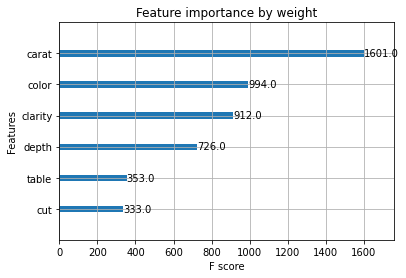

In [90]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(best_regressor, importance_type="weight")
plt.title("Feature importance by weight")




### Prediction Explanation: Shapley Additive Explanation

In [ ]:
!pip install shap

In [98]:
import shap
shap.initjs() # colab needs this for every cell that hosts a visualization
explainer = shap.TreeExplainer(best_regressor)
shap_values = explainer.shap_values(samples_test)
shap.force_plot(explainer.expected_value, shap_values[0,:], samples_test.iloc[0,:])

In [100]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, samples_test)

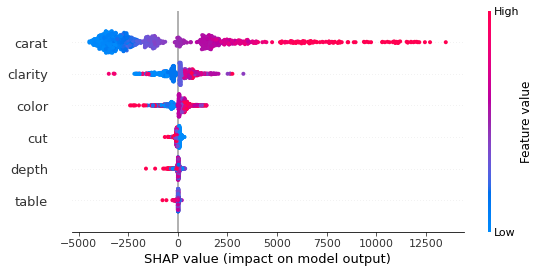

In [99]:
shap.initjs()
shap.summary_plot(shap_values, samples_test)

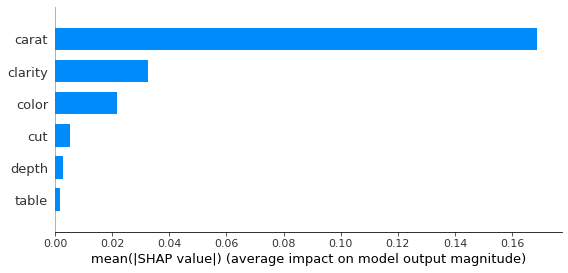

In [79]:
shap.initjs()
shap.summary_plot(shap_values, samples_test, plot_type="bar")